### **IMPORT**

In [ ]:
from keras import backend as K


import copy
from tensorflow.keras import optimizers
import keras
import numpy as np
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers import SpatialDropout2D
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf


### **DROPBLOCK FUNCTION**
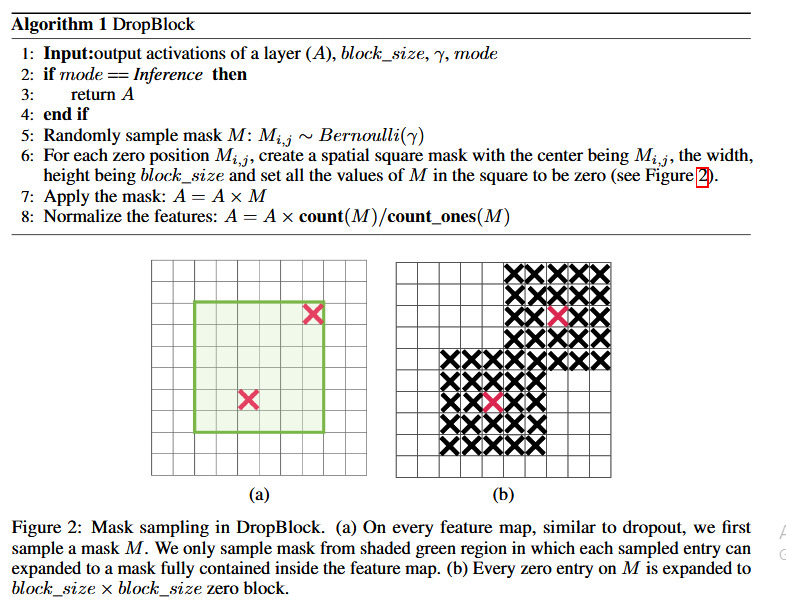


In [ ]:
from keras import backend as K

import copy

class NN_DropBlock(tf.keras.layers.Layer):

    def __init__(self, block_size, keep_prob, **kwargs):
        super(NN_DropBlock, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob

    def call(self, x, inference=None):

        # During inference, we do not Drop Blocks
        if inference == None:
            return x

        #padding
        z = self.block_size//2

        # Calculate Gamma
        feature_size = int(x.shape[-1])
        gamma = ((1-self.keep_prob)/(self.block_size**2)) * ((feature_size**2) / ((feature_size-self.block_size+1)**2))

        # Randomly sample mask
        sample_mask = tf.nn.relu(tf.sign(gamma - tf.random_uniform((feature_size-(z*2), feature_size-(z*2)), minval=0, maxval=1, dtype=tf.float32)))

        # The above code creates a matrix of zeros and samples ones from the distribution
        # We would like to flip all of these values
        sample_mask = 1-sample_mask

        # Pad the mask with ones
        sample_mask = np.pad(sample_mask, pad_width=z, mode='constant', constant_values=1)

        # For each 0, create spatial square mask of shape (block_size x block_size)
        spatial_square_mask = copy.copy(sample_mask)
        for i in range(feature_size):
            for j in range(feature_size):
                if sample_mask[i, j]==0:
                    spatial_square_mask[i-z : i+z+1, j-z : j+z+1] = 0

        spatial_square_mask = spatial_square_mask.reshape((1, feature_size, feature_size))

        # Apply the mask
        x = x * np.repeat(spatial_square_mask, x.shape[1], 0)

        # Normalize the features
        count = np.prod(spatial_square_mask.shape)
        count_ones = np.count_nonzero(spatial_square_mask == 1)
        x = x * count / count_ones

        return x

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob
                  }
        base_config = super(NN_DropBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape


### **CALLBACK FUNCTION**

In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs={}):
        # vary the rate wrt epochs. That's what you want
        self.model.get_layer(name = 'Drop1').keep_prob -= 0.008
        # vary the rate wrt epochs. That's what you want
        self.model.get_layer(name = 'Drop2').keep_prob -= 0.008
        # vary the rate wrt epochs. That's what you want
        self.model.get_layer(name = 'Drop2').keep_prob -= 0.008

### **CNN Standard**

170508288/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
196/196 [==============================] - 54s 35ms/step - loss: 2.0848 - accuracy: 0.4147 - val_loss: 1.3409 - val_accuracy: 0.5572
Epoch 2/100
196/196 [==============================] - 6s 28ms/step - loss: 1.0354 - accuracy: 0.6748 - val_loss: 1.1435 - val_accuracy: 0.6452
Epoch 3/100
196/196 [==============================] - 6s 28ms/step - loss: 0.7826 - accuracy: 0.7532 - val_loss: 1.1495 - val_accuracy: 0.6526
Epoch 4/100
196/196 [==============================] - 6s 28ms/step - loss: 0.6076 - accuracy: 0.8077 - val_loss: 1.1524 - val_accuracy: 0.6810
Epoch 5/100
196/196 [==============================] - 6s 28ms/step - loss: 0.4778 - accuracy: 0.8523 - val_loss: 0.8857 - val_accuracy: 0.7440
Epoch 6/100
196/196 [==============================] - 6s 29ms/step - loss: 0.3838 - accuracy: 0.8835 - val_loss: 0.9600 - val_accuracy: 0.7290
Epoch 7/100
196/196 [==============================] - 6s 29ms/step - loss: 0.3009 - accuracy: 0.9166 - val_loss: 0.9965 - val_accuracy

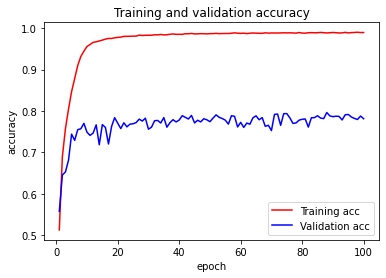

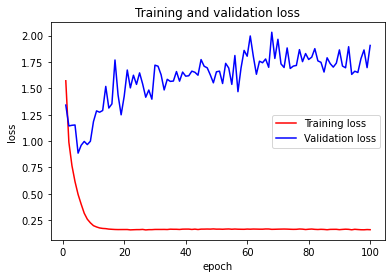

In [ ]:
batch_size = 256
num_classes = 10
epochs = 100

# input image dimensions
img_chan, img_rows, img_cols = 3, 32, 32
# number of convolutional filters to use
nb_filters = 18
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3


# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

epochs = range(1, len(acc1) + 1)

plt.plot(epochs, acc1, 'r', label='Training acc')
plt.plot(epochs, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, 'r', label='Training loss')
plt.plot(epochs, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPOUT(0.25)**

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
196/196 [==============================] - 9s 33ms/step - loss: 2.3301 - accuracy: 0.3637 - val_loss: 1.9185 - val_accuracy: 0.3381
Epoch 2/100
196/196 [==============================] - 6s 29ms/step - loss: 1.2802 - accuracy: 0.6014 - val_loss: 1.4303 - val_accuracy: 0.5992
Epoch 3/100
196/196 [==============================] - 6s 29ms/step - loss: 1.0515 - accuracy: 0.6842 - val_loss: 1.3925 - val_accuracy: 0.5555
Epoch 4/100
196/196 [==============================] - 6s 29ms/step - loss: 0.9478 - accuracy: 0.7168 - val_loss: 1.1365 - val_accuracy: 0.6743
Epoch 5/100
196/196 [==============================] - 6s 29ms/step - loss: 0.8101 - accuracy: 0.7573 - val_loss: 1.3511 - val_accuracy: 0.6092
Epoch 6/100
196/196 [==============================] - 6s 30ms/step - loss: 0.7482 - accuracy: 0.7753 - val_loss: 0.7756 - val_accuracy: 0.7645
Epoch 7/100
196/196 [==============================] - 6s 29ms/step - loss: 0.6814 - accuracy: 0.7927 - val_loss: 0.8590 - val_accuracy:

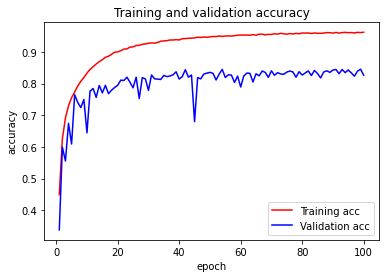

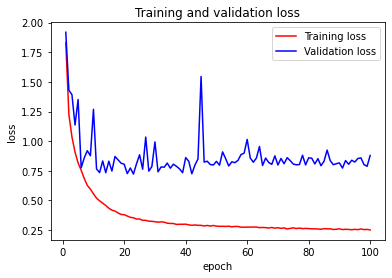

In [ ]:
batch_size = 256
num_classes = 10
epochs = 100

# input image dimensions
img_chan, img_rows, img_cols = 3, 32, 32
# number of convolutional filters to use
nb_filters = 18
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3


# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, acc2, 'r', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'r', label='Training loss')
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **SPATIALDROPOUT(0.7)**

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
196/196 [==============================] - 9s 33ms/step - loss: 3.2309 - accuracy: 0.1891 - val_loss: 2.0031 - val_accuracy: 0.3451
Epoch 2/100
196/196 [==============================] - 6s 29ms/step - loss: 2.0517 - accuracy: 0.3299 - val_loss: 1.8923 - val_accuracy: 0.3590
Epoch 3/100
196/196 [==============================] - 6s 29ms/step - loss: 1.9508 - accuracy: 0.3778 - val_loss: 1.9778 - val_accuracy: 0.3592
Epoch 4/100
196/196 [==============================] - 6s 29ms/step - loss: 1.8561 - accuracy: 0.4066 - val_loss: 2.5055 - val_accuracy: 0.2520
Epoch 5/100
196/196 [==============================] - 6s 29ms/step - loss: 1.7970 - accuracy: 0.4359 - val_loss: 1.5612 - val_accuracy: 0.4872
Epoch 6/100
196/196 [==============================] - 6s 29ms/step - loss: 1.6895 - accuracy: 0.4578 - val_loss: 1.4524 - val_accuracy: 0.4965
Epoch 7/100
196/196 [==============================] - 6s 29ms/step - loss: 1.6475 - accuracy: 0.4768 - val_loss: 1.4023 - val_accuracy:

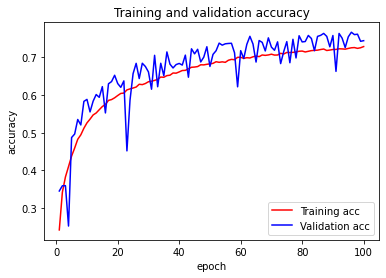

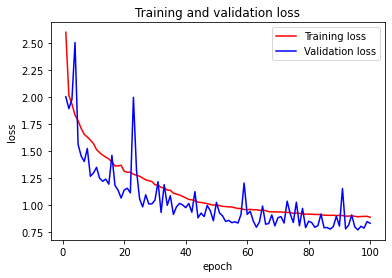

In [ ]:
batch_size = 256
num_classes = 10
epochs = 100

# input image dimensions
img_chan, img_rows, img_cols = 3, 32, 32
# number of convolutional filters to use
nb_filters = 18
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3


# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(SpatialDropout2D(0.7))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(SpatialDropout2D(0.7))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(SpatialDropout2D(0.7))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

epochs = range(1, len(acc3) + 1)

plt.plot(epochs, acc3, 'r', label='Training acc')
plt.plot(epochs, val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'r', label='Training loss')
plt.plot(epochs, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPBLOCK**

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_18 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 32, 32, 32)        128       
_______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


196/196 [==============================] - 12s 36ms/step - loss: 2.1345 - accuracy: 0.4039 - val_loss: 1.6369 - val_accuracy: 0.4564
Epoch 2/100
196/196 [==============================] - 6s 33ms/step - loss: 1.1635 - accuracy: 0.6449 - val_loss: 1.1343 - val_accuracy: 0.6477
Epoch 3/100
196/196 [==============================] - 6s 33ms/step - loss: 0.9131 - accuracy: 0.7143 - val_loss: 1.0464 - val_accuracy: 0.6832
Epoch 4/100
196/196 [==============================] - 6s 33ms/step - loss: 0.7607 - accuracy: 0.7661 - val_loss: 0.8769 - val_accuracy: 0.7320
Epoch 5/100
196/196 [==============================] - 6s 33ms/step - loss: 0.6244 - accuracy: 0.8026 - val_loss: 1.0716 - val_accuracy: 0.6723
Epoch 6/100
196/196 [==============================] - 6s 33ms/step - loss: 0.5314 - accuracy: 0.8347 - val_loss: 0.9730 - val_accuracy: 0.7229
Epoch 7/100
196/196 [==============================] - 6s 33ms/step - loss: 0.4452 - accuracy: 0.8649 - val_loss: 0.8629 - val_accuracy: 0.7530
Epo

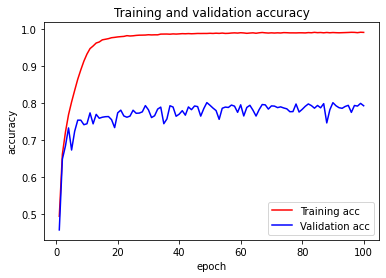

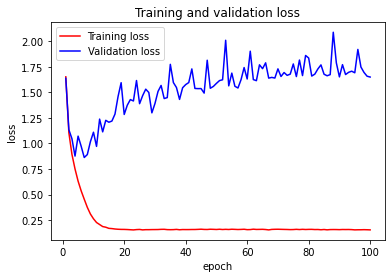

In [ ]:
batch_size = 256
num_classes = 10
epochs = 100

# input image dimensions
img_chan, img_rows, img_cols = 3, 32, 32
# number of convolutional filters to use
nb_filters = 18
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3


# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlockk(block_size=3, keep_prob=0.9, name = 'Drop1'))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=3, keep_prob=0.9, name = 'Drop2'))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=3, keep_prob=0.9, name = 'Drop3'))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc4 = history.history['accuracy']
val_acc4 = history.history['val_accuracy']
loss4 = history.history['loss']
val_loss4 = history.history['val_loss']

epochs = range(1, len(acc4) + 1)

plt.plot(epochs, acc4, 'r', label='Training acc')
plt.plot(epochs, val_acc4, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss4, 'r', label='Training loss')
plt.plot(epochs, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPBLOCK 7**

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_24 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 32)        128       
_______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


196/196 [==============================] - 11s 39ms/step - loss: 2.1064 - accuracy: 0.3936 - val_loss: 1.8069 - val_accuracy: 0.4461
Epoch 2/100
196/196 [==============================] - 7s 35ms/step - loss: 1.1726 - accuracy: 0.6277 - val_loss: 1.4198 - val_accuracy: 0.5458
Epoch 3/100
196/196 [==============================] - 7s 35ms/step - loss: 0.9211 - accuracy: 0.7138 - val_loss: 1.0220 - val_accuracy: 0.6877
Epoch 4/100
196/196 [==============================] - 7s 35ms/step - loss: 0.7525 - accuracy: 0.7679 - val_loss: 0.9894 - val_accuracy: 0.7071
Epoch 5/100
196/196 [==============================] - 7s 35ms/step - loss: 0.6113 - accuracy: 0.8102 - val_loss: 0.9111 - val_accuracy: 0.7279
Epoch 6/100
196/196 [==============================] - 7s 35ms/step - loss: 0.4909 - accuracy: 0.8481 - val_loss: 1.0172 - val_accuracy: 0.7189
Epoch 7/100
196/196 [==============================] - 7s 35ms/step - loss: 0.4022 - accuracy: 0.8821 - val_loss: 0.9222 - val_accuracy: 0.7561
Epo

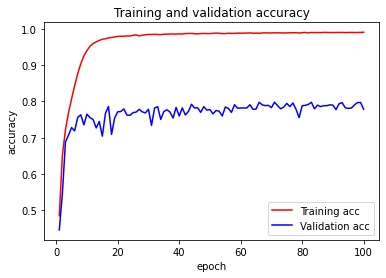

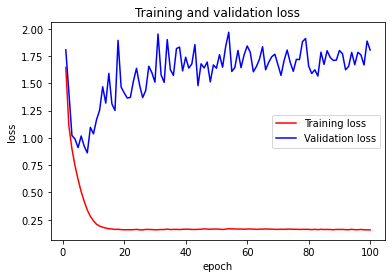

In [ ]:
batch_size = 256
num_classes = 10
epochs = 100

# input image dimensions
img_chan, img_rows, img_cols = 3, 32, 32
# number of convolutional filters to use
nb_filters = 18
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3


# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=7, keep_prob=0.9, name = 'Drop1'))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=7, keep_prob=0.9, name = 'Drop2'))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=7, keep_prob=0.9, name = 'Drop3'))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc5 = history.history['accuracy']
val_acc5 = history.history['val_accuracy']
loss5 = history.history['loss']
val_loss5 = history.history['val_loss']
print(acc5)
print(val_acc5)
print(loss5)
print(val_loss5)
print(epochs)
epochs = range(1, len(acc5) + 1)

plt.plot(epochs, acc5, 'r', label='Training acc')
plt.plot(epochs, val_acc5, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss5, 'r', label='Training loss')
plt.plot(epochs, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **MERGE RESULTS**

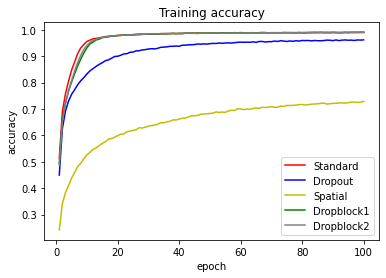

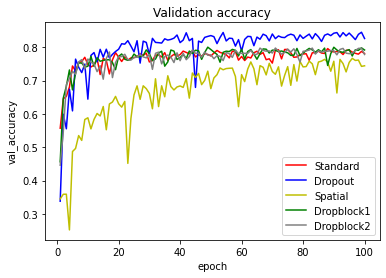

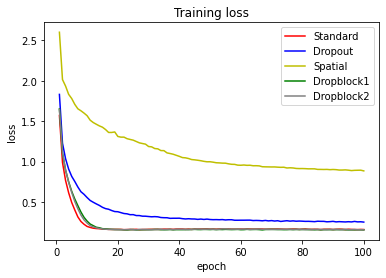

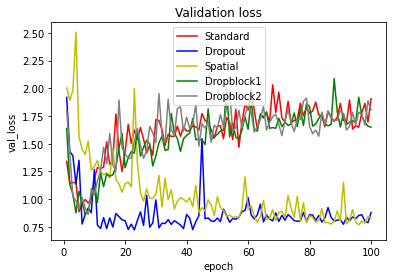

In [ ]:
plt.plot(epochs, acc1, 'r', label='Standard')
plt.plot(epochs, acc2, 'b', label='Dropout')
plt.plot(epochs, acc3, 'y', label='Spatial')
plt.plot(epochs, acc4, 'g', label='Dropblock1')
plt.plot(epochs, acc5, 'grey', label='Dropblock2')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_acc1, 'r', label='Standard')
plt.plot(epochs, val_acc2, 'b', label='Dropout')
plt.plot(epochs, val_acc3, 'y', label='Spatial')
plt.plot(epochs, val_acc4, 'g', label='Dropblock1')
plt.plot(epochs, val_acc5, 'grey', label='Dropblock2')
plt.title('Validation accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.plot(epochs, loss1, 'r', label='Standard')
plt.plot(epochs, loss2, 'b', label='Dropout')
plt.plot(epochs, loss3, 'y', label='Spatial')
plt.plot(epochs, loss4, 'g', label='Dropblock1')
plt.plot(epochs, loss5, 'grey', label='Dropblock2')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_loss1, 'r', label='Standard')
plt.plot(epochs, val_loss2, 'b', label='Dropout')
plt.plot(epochs, val_loss3, 'y', label='Spatial')
plt.plot(epochs, val_loss4, 'g', label='Dropblock1')
plt.plot(epochs, val_loss5, 'grey', label='Dropblock2')
plt.title('Validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()